# Classification - Doc2Vec

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Doc2Vec](https://radimrehurek.com/gensim_3.8.3/models/doc2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import Doc2VecTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

transformer = Doc2VecTransformer.load('doc2vec')
train = transformer.fit(X_train)

In [4]:
test = transformer.transform(X_test)

<a id='data_preparation'/>

## Data Preparation

In [5]:
def create_classifier(classifier, name):
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    #experimental_classifier.train(train, y_train)
    #experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [6]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 76.27636694908142s
Test: 0.061362504959106445s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.024383631388022655     0.003990326481257557     0.10874647319629181      0.10883514711809755      0.09939377363198404      
micro                                                            0.1039592708759489       0.10948346019436067      0.10664987875396381      
macro                                                            0.03660010385642078      0.037981143240158055     0.037131329451119834     


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 0.9465596675872803s
Test: 90.63134479522705s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013180805702284732     0.04885126964933494      0.17735792019347038      0.08295042321644498      0.10687856279150111      
micro                                                            0.5285073670723895       0.07898894154818326      0.1374370080379826       
macro                                                            0.23687247740865236      0.027264107708750013     0.04498031199208422      


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [8]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 111.18141150474548s
Test: 0.06784701347351074s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013068796537898556     0.05973397823458283      0.34634450394426214      0.20785771866182992      0.24126103843758012      
micro                                                            0.5219059405940594       0.20187658576284168      0.2911388035486209       
macro                                                            0.33849144103022694      0.13960900013562563      0.18556977476916545      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 575.4205839633942s
Test: 0.7350418567657471s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012716222236364793     0.05538089480048368      0.21232912995911787      0.11230149133413946      0.1376839216137886       
micro                                                            0.6215854311730048       0.1111111111111111       0.18852292571985543      
macro                                                            0.23662497950181266      0.043244677829879834     0.06495873790386614      


In [10]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 26.97082209587097s
Test: 0.806842565536499s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013457010119009738     0.051390568319226115     0.26861221153117226      0.18266021765417173      0.19639741270299985      
micro                                                            0.48389126604580923      0.18406816985016036      0.2666897867175308       
macro                                                            0.3042910235834853       0.12026726313350174      0.16194533928707805      


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [11]:
from skmultilearn.problem_transform import ClassifierChain

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 440.09254360198975s
Test: 2.5782952308654785s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012707312416470438     0.058645707376058044     0.2650819562004567       0.14479040709391375      0.17531707644766895      
micro                                                            0.5919425608296769       0.1420843506151563       0.22916264525344554      
macro                                                            0.2858041522292579       0.0682976049531906       0.0973972150903337       


In [12]:
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Training: 87.58442544937134s
Test: 2.549346446990967s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01343409915356711      0.057799274486094315     0.2970840418482499       0.20300080612656188      0.21943120227884433      
micro                                                            0.48730671590122315      0.20216381827756236      0.2857722889527999       
macro                                                            0.3049837549506505       0.1281596617636677       0.16928884799055832      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [13]:
from skmultilearn.problem_transform import LabelPowerset

create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

Training: 1368.6269464492798s
Test: 1.5733201503753662s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.021027174950677782     0.01717049576783555      0.23392583635630793      0.1803929866989117       0.18533818928619414      
micro                                                            0.1891850411827902       0.17703097323950404      0.18290632110000987      
macro                                                            0.09766139185523921      0.09077917819329548      0.09276415084208996      


In [14]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression
create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

Training: 1539.2145681381226s
Test: 1.93672776222229s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014385540635142875     0.04268440145102781      0.4307194679564692       0.23454655380894798      0.2850065257864532       
micro                                                            0.42233493342994294      0.22322753602374457      0.2920764171625431       
macro                                                            0.25895784180538806      0.09682338410257547      0.12731302085386986      


<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [15]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Training: 294.2208788394928s
Test: 100.74386668205261s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013298542608031566     0.052962515114873036     0.2613986295848448       0.13766424828698107      0.1687763190725706       
micro                                                            0.499371746544606        0.13318014265881564      0.21027966742252455      
macro                                                            0.27156017711272884      0.05862752367723445      0.08853517824979555      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [16]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 35.39668679237366s
Test: 226.74313640594482s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01710112645580093      0.025030229746070134     0.3575491203549841       0.22192261185006046      0.24775952971717358      
micro                                                            0.2996382636655949       0.21413183972425678      0.24976966245079155      
macro                                                            0.14192316760561402      0.049015527374583624     0.055665691818524494     


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [17]:
from skmultilearn.ensemble import RakelO

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Training: 3095.4035584926605s
Test: 118.41306829452515s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012769681155730923     0.05175332527206771      0.18640467553405884      0.09223498589278516      0.11630563712788623      
micro                                                            0.6367861885790173       0.09181866053903968      0.16049537676247855      
macro                                                            0.15316517652897724      0.0237991694314145       0.03736942002105546      


In [18]:
create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Training: 370.52514123916626s
Test: 119.96998405456543s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013464010691783873     0.05344619105199516      0.26955103139504594      0.18479040709391376      0.19812030601415556      
micro                                                            0.48337277369535436      0.18579156493848437      0.26841413652396434      
macro                                                            0.29799527974185985      0.12219491689906783      0.16328009254607176      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [19]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Training: 1012.126787185669s
Test: 36.408055543899536s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012868962005982308     0.05066505441354292      0.17637646110439337      0.08843611446997177      0.11097447091401143      
micro                                                            0.6103767349636484       0.08841974244817846      0.15446372569517036      
macro                                                            0.1491839600898399       0.023940790848087538     0.037426221018412774     


In [20]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Training: 93.14573168754578s
Test: 36.9341824054718s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013516196779736523     0.05259975816203144      0.27088899847968767      0.18747279322853688      0.19969524765587224      
micro                                                            0.47876870665531085      0.18837665757097036      0.27037240621135084      
macro                                                            0.30104692624358603      0.12634089701838583      0.16752655504097633      


***Clustering***

In [21]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [22]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [23]:
clusterer_igraph = get_clusterer()

190 labels, 7716 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [24]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Training: 69.36259269714355s
Test: 5.972095727920532s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013481193915865844     0.05392986698911729      0.2688883757737919       0.18759572752922207      0.19927400362399295      
micro                                                            0.4820293398533007       0.18875963425726458      0.2712855619388352       
macro                                                            0.3040693392764102       0.1252751844800329       0.16663963290039285      


In [25]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

Training: 494.45103788375854s
Test: 4.8655619621276855s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012700948259403043     0.055864570737605805     0.22442765014107213      0.12068722289399435      0.14682310233096205      
micro                                                            0.6144963144963145       0.11972808655273111      0.2004086702191594       
macro                                                            0.2663831446187391       0.053900461180983246     0.08049119530691154      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [26]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

Training: 69.15930509567261s
Test: 2.1822245121002197s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013481193915865844     0.05392986698911729      0.2688883757737919       0.18759572752922207      0.19927400362399295      
micro                                                            0.4820293398533007       0.18875963425726458      0.2712855619388352       
macro                                                            0.3040693392764102       0.1252751844800329       0.16663963290039285      


In [27]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

Training: 495.7340052127838s
Test: 2.125823736190796s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012700948259403043     0.055864570737605805     0.22442765014107213      0.12068722289399435      0.14682310233096205      
micro                                                            0.6144963144963145       0.11972808655273111      0.2004086702191594       
macro                                                            0.2663831446187391       0.053900461180983246     0.08049119530691154      


<a id='evaluation'/>

## Evaluation

In [28]:
paths = available_classifier_paths('doc2vec')
evals = []
for path in paths:
    if '-' not in path.name:
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([str(clf), evaluation])

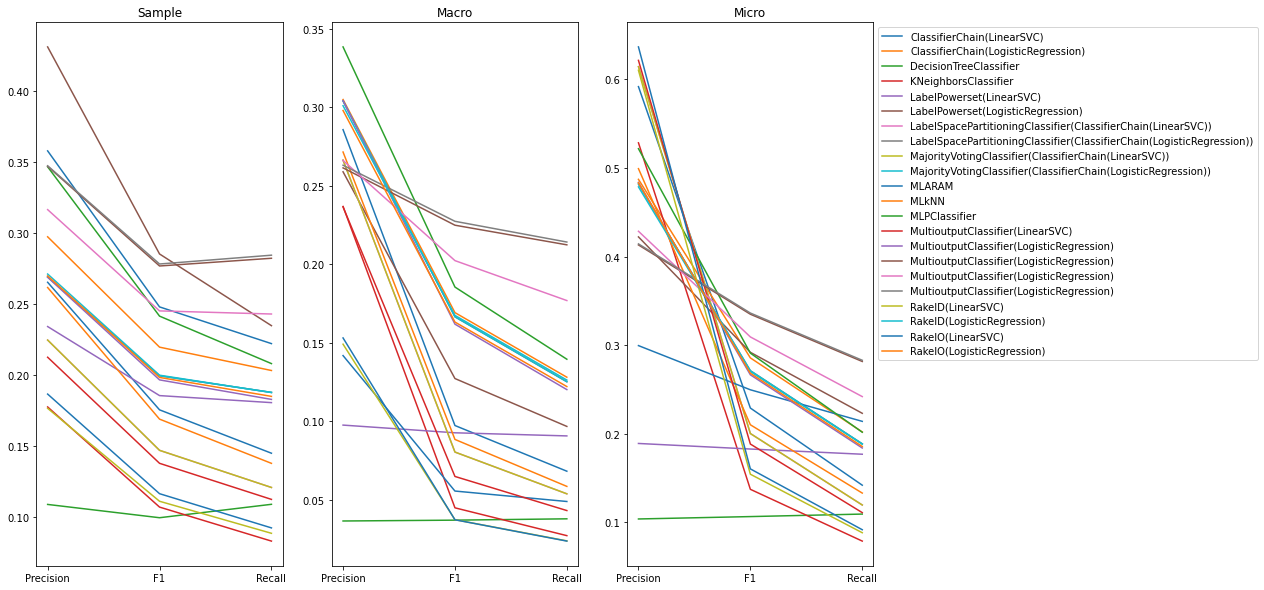

In [29]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [30]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [31]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray() 
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [32]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

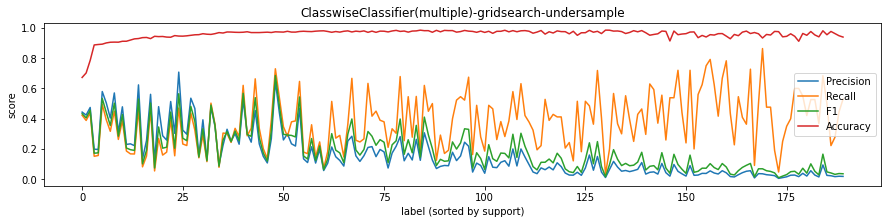

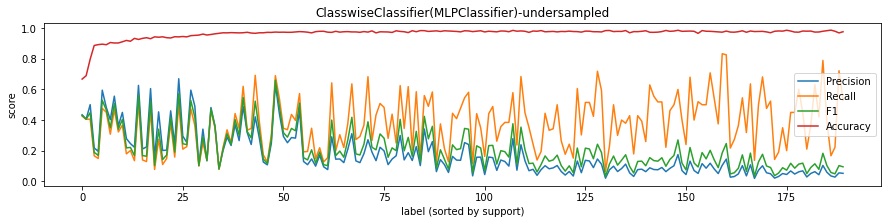

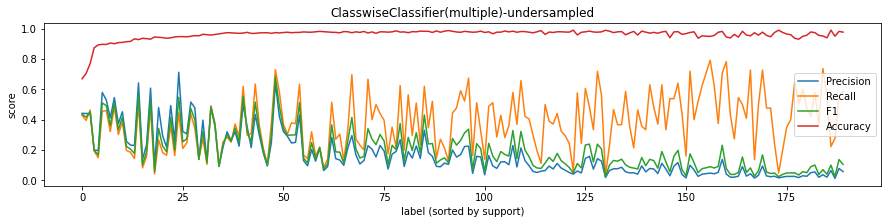

In [33]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Impact of vector size**

In [34]:
transformer = Doc2VecTransformer.load('doc2vec', 100)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 26.97082209587097s
Test: 0.806842565536499s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013457010119009738     0.051390568319226115     0.26861221153117226      0.18266021765417173      0.19639741270299985      
micro                                                            0.48389126604580923      0.18406816985016036      0.2666897867175308       
macro                                                            0.3042910235834853       0.12026726313350174      0.16194533928707805      


In [35]:
transformer = Doc2VecTransformer.load('doc2vec', 200)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 71.2961859703064s
Test: 2.6025819778442383s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014364538916820466     0.05513905683192261      0.3162120665329519       0.24275292220878678      0.2449396073220472       
micro                                                            0.4287046456425907       0.24208913782373498      0.3094385803885574       
macro                                                            0.2661827708121127       0.17697275574417184      0.2024034976858967       


In [36]:
transformer = Doc2VecTransformer.load('doc2vec', 500)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 180.48517203330994s
Test: 3.8857486248016357s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014848214853942596     0.05562273276904474      0.34707579019009044      0.2841475211608222       0.27795021495312544      
micro                                                            0.4144238856181665       0.28306764325721673      0.33637682396108887      
macro                                                            0.26315135727039773      0.21423475778988296      0.22743918275801847      


In [37]:
transformer = Doc2VecTransformer.load('doc2vec', 1000)
train = transformer.fit(X_train)
test = transformer.transform(X_test)
create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Training: 354.3196189403534s
Test: 7.807853937149048s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014866034493731306     0.05513905683192261      0.34669497219767414      0.28197904070939134      0.2765456116940463       
micro                                                            0.41327247191011235      0.2817272248551869       0.33505081271883624      
macro                                                            0.26146816204551065      0.21245708367283672      0.22495145329976488      


In [38]:
import re
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths
paths = available_classifier_paths('doc2vec', 'size')
evals = []
for path in paths:
    if 'MultioutputClassifier(LogisticRegression)' in str(path):
        clf = load(path)
        evaluation = clf.evaluation
        matches = re.findall(r'=([\w,\d]*)', str(path))
        _, _, size = matches
        evals.append([int(size), evaluation])

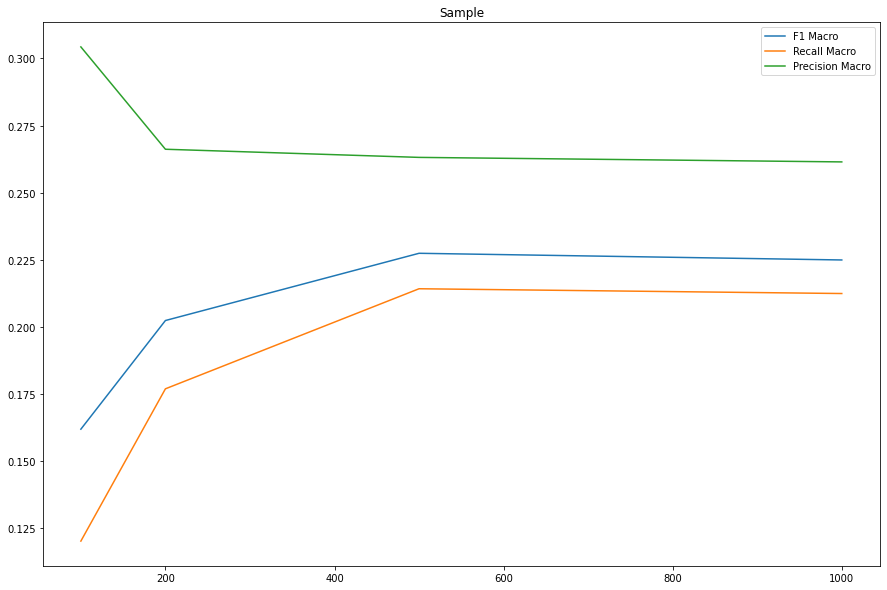

In [39]:
fig, axes = plt.subplots(figsize=(15,10))
axes.set_title('Sample')
evals = sorted(evals, key=lambda x: x[0])
x_ = [eval[0] for eval in evals]
axes.plot(x_, [eval[1].f1_macro for eval in evals], label='F1 Macro')
axes.plot(x_, [eval[1].recall_macro for eval in evals], label='Recall Macro')
axes.plot(x_, [eval[1].precision_macro for eval in evals], label='Precision Macro')
axes.legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()